In [1]:
from __future__ import print_function

In [2]:
pip install vit-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.4 MB/s 


In [3]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import glob
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

from itertools import chain
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from vit_pytorch.pit import PiT

In [6]:
# Training settings
batch_size = 32
epochs = 200
lr = 0.0001
gamma = 0.7
seed = 42

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [8]:
'''
IMAGE CATEGORY ENCODING

Benign = 0
Malignant = 1
'''

'\nIMAGE CATEGORY ENCODING\n\nBenign = 0\nMalignant = 1\n'

In [9]:
from google.colab import drive
drive.mount('/content/drive')

train_list = glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10253', '*', '*.png'))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10254', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10255', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10256', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10257', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10258', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10259', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10260', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10261', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10264', '*', '*.png')))

print(f"Train list length: {len(train_list)}")

Mounted at /content/drive
Train list length: 7906


In [10]:
random.shuffle(train_list)

In [11]:
train_list, test_list = train_test_split(train_list,
                                          test_size=0.15,
                                          random_state=42)

In [12]:
test_list, valid_list = train_test_split(test_list,
                                          test_size=0.33,
                                          random_state=42)

In [13]:
print(f"Train Data: {len(train_list)}")
print(f"Valid Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 6720
Valid Data: 392
Test Data: 794


In [14]:
device = 'cuda'

In [15]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(0, 180)),
        transforms.ColorJitter(brightness=.5, hue=.3),
        transforms.ToTensor(),
    ]
)

valid_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [16]:
class IDCDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-2].split(".")[0]
        label = 1 if label == "1" else 0

        return img_transformed, label

In [17]:
train_data = IDCDataset(train_list, transform=train_transforms)
valid_data = IDCDataset(valid_list, transform=valid_transforms)
test_data = IDCDataset(test_list, transform=test_transforms)

In [18]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [19]:
model = PiT(
    image_size = 224,
    patch_size = 16,
    dim = 64,
    num_classes = 2,
    depth = (4, 4, 4),     # list of depths, indicating the number of rounds of each stage before a downsample
    heads = 8,
    mlp_dim = 64,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

In [20]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [21]:
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

bestloss = 100
patience = 15
triggers = 0
batchmul = 2

In [22]:
start_time = time.time()

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    model.train()
    for idx, (data, label) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)/batchmul
        loss.backward()

        if ((idx + 1) % batchmul == 0) or (idx + 1 == len(train_loader)):
          optimizer.step()
          optimizer.zero_grad()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += (loss.item())*batchmul / len(train_loader)

    model.eval()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss.item() / len(valid_loader)
    
    train_loss_list.append(epoch_loss)
    train_accuracy_list.append(epoch_accuracy)
    val_loss_list.append(epoch_val_loss)
    val_accuracy_list.append(epoch_val_accuracy)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    if(epoch_loss < bestloss):
        triggers = 0
        bestloss = epoch_loss
        #torch.save(model.state_dict(), "/content/drive/MyDrive/SavedViTModels/PiTSavedModel2.pth")
        #torch.save(optimizer.state_dict(), "/content/drive/MyDrive/SavedViTModels/PiTSavedOptimizer2.pth")
    else:
        triggers += 1

    if triggers == patience:
        print("Early stopping since epoch_loss > bestloss for 15 epochs")
        break

end_time = time.time()

print(f"\nTime taken to train the model: {(end_time - start_time)/60/60} hours")

100%|██████████| 210/210 [17:57<00:00,  5.13s/it]


Epoch : 1 - loss : 0.5151 - acc: 0.7827 - val_loss : 0.4624 - val_acc: 0.7692



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 2 - loss : 0.4859 - acc: 0.7812 - val_loss : 0.4819 - val_acc: 0.7692



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 3 - loss : 0.4861 - acc: 0.7857 - val_loss : 0.4884 - val_acc: 0.7764



100%|██████████| 210/210 [01:45<00:00,  1.98it/s]


Epoch : 4 - loss : 0.4693 - acc: 0.7897 - val_loss : 0.4975 - val_acc: 0.7692



100%|██████████| 210/210 [01:47<00:00,  1.96it/s]


Epoch : 5 - loss : 0.4792 - acc: 0.7881 - val_loss : 0.5091 - val_acc: 0.7692



100%|██████████| 210/210 [01:45<00:00,  2.00it/s]


Epoch : 6 - loss : 0.4812 - acc: 0.7856 - val_loss : 0.4998 - val_acc: 0.7692



100%|██████████| 210/210 [01:47<00:00,  1.95it/s]


Epoch : 7 - loss : 0.4789 - acc: 0.7869 - val_loss : 0.4603 - val_acc: 0.7620



100%|██████████| 210/210 [01:44<00:00,  2.00it/s]


Epoch : 8 - loss : 0.4769 - acc: 0.7868 - val_loss : 0.4586 - val_acc: 0.7548



100%|██████████| 210/210 [01:46<00:00,  1.97it/s]


Epoch : 9 - loss : 0.4777 - acc: 0.7882 - val_loss : 0.5253 - val_acc: 0.7548



100%|██████████| 210/210 [01:47<00:00,  1.96it/s]


Epoch : 10 - loss : 0.4766 - acc: 0.7853 - val_loss : 0.4441 - val_acc: 0.7620



100%|██████████| 210/210 [01:46<00:00,  1.98it/s]


Epoch : 11 - loss : 0.4746 - acc: 0.7862 - val_loss : 0.4563 - val_acc: 0.7692



100%|██████████| 210/210 [01:52<00:00,  1.87it/s]


Epoch : 12 - loss : 0.4722 - acc: 0.7857 - val_loss : 0.4578 - val_acc: 0.7692



100%|██████████| 210/210 [01:51<00:00,  1.89it/s]


Epoch : 13 - loss : 0.4780 - acc: 0.7896 - val_loss : 0.4529 - val_acc: 0.7692



100%|██████████| 210/210 [01:47<00:00,  1.96it/s]


Epoch : 14 - loss : 0.4767 - acc: 0.7878 - val_loss : 0.4842 - val_acc: 0.7548



100%|██████████| 210/210 [01:46<00:00,  1.96it/s]


Epoch : 15 - loss : 0.4761 - acc: 0.7844 - val_loss : 0.4547 - val_acc: 0.7740



100%|██████████| 210/210 [01:44<00:00,  2.02it/s]


Epoch : 16 - loss : 0.4711 - acc: 0.7856 - val_loss : 0.4410 - val_acc: 0.7692



100%|██████████| 210/210 [01:43<00:00,  2.03it/s]


Epoch : 17 - loss : 0.4737 - acc: 0.7850 - val_loss : 0.4853 - val_acc: 0.7548



100%|██████████| 210/210 [01:43<00:00,  2.03it/s]


Epoch : 18 - loss : 0.4657 - acc: 0.7884 - val_loss : 0.4281 - val_acc: 0.7764



100%|██████████| 210/210 [01:43<00:00,  2.03it/s]


Epoch : 19 - loss : 0.4735 - acc: 0.7887 - val_loss : 0.4547 - val_acc: 0.7692



100%|██████████| 210/210 [01:43<00:00,  2.03it/s]


Epoch : 20 - loss : 0.4710 - acc: 0.7872 - val_loss : 0.4643 - val_acc: 0.7692



100%|██████████| 210/210 [01:43<00:00,  2.03it/s]


Epoch : 21 - loss : 0.4694 - acc: 0.7890 - val_loss : 0.4817 - val_acc: 0.7692



100%|██████████| 210/210 [01:43<00:00,  2.02it/s]


Epoch : 22 - loss : 0.4748 - acc: 0.7881 - val_loss : 0.4701 - val_acc: 0.7620



100%|██████████| 210/210 [01:43<00:00,  2.04it/s]


Epoch : 23 - loss : 0.4716 - acc: 0.7888 - val_loss : 0.4790 - val_acc: 0.7620



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 24 - loss : 0.4709 - acc: 0.7897 - val_loss : 0.4572 - val_acc: 0.7692



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 25 - loss : 0.4655 - acc: 0.7884 - val_loss : 0.4796 - val_acc: 0.7692



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 26 - loss : 0.4608 - acc: 0.7891 - val_loss : 0.4549 - val_acc: 0.7620



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 27 - loss : 0.4451 - acc: 0.7936 - val_loss : 0.4460 - val_acc: 0.7620



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 28 - loss : 0.4373 - acc: 0.8052 - val_loss : 0.4269 - val_acc: 0.8125



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 29 - loss : 0.4207 - acc: 0.8062 - val_loss : 0.4449 - val_acc: 0.7861



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 30 - loss : 0.4238 - acc: 0.8074 - val_loss : 0.4374 - val_acc: 0.8005



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 31 - loss : 0.4060 - acc: 0.8137 - val_loss : 0.4020 - val_acc: 0.8077



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 32 - loss : 0.4122 - acc: 0.8159 - val_loss : 0.4101 - val_acc: 0.8221



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 33 - loss : 0.3977 - acc: 0.8210 - val_loss : 0.3958 - val_acc: 0.8125



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 34 - loss : 0.3963 - acc: 0.8208 - val_loss : 0.3962 - val_acc: 0.8221



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 35 - loss : 0.3910 - acc: 0.8263 - val_loss : 0.3468 - val_acc: 0.8510



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 36 - loss : 0.3797 - acc: 0.8293 - val_loss : 0.4027 - val_acc: 0.8029



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 37 - loss : 0.3744 - acc: 0.8329 - val_loss : 0.3592 - val_acc: 0.8510



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 38 - loss : 0.3677 - acc: 0.8433 - val_loss : 0.4007 - val_acc: 0.8365



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 39 - loss : 0.3679 - acc: 0.8351 - val_loss : 0.3809 - val_acc: 0.8245



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 40 - loss : 0.3619 - acc: 0.8429 - val_loss : 0.3965 - val_acc: 0.8462



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 41 - loss : 0.3547 - acc: 0.8427 - val_loss : 0.3547 - val_acc: 0.8486



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 42 - loss : 0.3452 - acc: 0.8501 - val_loss : 0.4057 - val_acc: 0.8486



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 43 - loss : 0.3404 - acc: 0.8503 - val_loss : 0.4348 - val_acc: 0.8293



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 44 - loss : 0.3382 - acc: 0.8573 - val_loss : 0.4641 - val_acc: 0.7933



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 45 - loss : 0.3392 - acc: 0.8531 - val_loss : 0.3993 - val_acc: 0.8293



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 46 - loss : 0.3325 - acc: 0.8518 - val_loss : 0.3393 - val_acc: 0.8654



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 47 - loss : 0.3345 - acc: 0.8519 - val_loss : 0.3368 - val_acc: 0.8582



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 48 - loss : 0.3306 - acc: 0.8565 - val_loss : 0.3236 - val_acc: 0.8654



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 49 - loss : 0.3303 - acc: 0.8543 - val_loss : 0.3472 - val_acc: 0.8702



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 50 - loss : 0.3188 - acc: 0.8641 - val_loss : 0.3258 - val_acc: 0.8750



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 51 - loss : 0.3246 - acc: 0.8594 - val_loss : 0.4952 - val_acc: 0.8558



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 52 - loss : 0.3286 - acc: 0.8574 - val_loss : 0.3316 - val_acc: 0.8678



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 53 - loss : 0.3148 - acc: 0.8658 - val_loss : 0.3643 - val_acc: 0.8582



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 54 - loss : 0.3217 - acc: 0.8619 - val_loss : 0.3466 - val_acc: 0.8630



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 55 - loss : 0.3169 - acc: 0.8640 - val_loss : 0.3419 - val_acc: 0.8486



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 56 - loss : 0.3118 - acc: 0.8631 - val_loss : 0.3399 - val_acc: 0.8750



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 57 - loss : 0.3142 - acc: 0.8670 - val_loss : 0.3180 - val_acc: 0.8702



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 58 - loss : 0.3079 - acc: 0.8618 - val_loss : 0.3103 - val_acc: 0.8726



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 59 - loss : 0.3098 - acc: 0.8659 - val_loss : 0.3061 - val_acc: 0.8678



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 60 - loss : 0.3095 - acc: 0.8658 - val_loss : 0.3444 - val_acc: 0.8630



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 61 - loss : 0.3038 - acc: 0.8735 - val_loss : 0.2931 - val_acc: 0.8702



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 62 - loss : 0.3094 - acc: 0.8644 - val_loss : 0.3109 - val_acc: 0.8606



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 63 - loss : 0.3079 - acc: 0.8686 - val_loss : 0.3565 - val_acc: 0.8365



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 64 - loss : 0.3091 - acc: 0.8682 - val_loss : 0.3155 - val_acc: 0.8582



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 65 - loss : 0.2988 - acc: 0.8708 - val_loss : 0.3093 - val_acc: 0.8654



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 66 - loss : 0.2961 - acc: 0.8729 - val_loss : 0.3420 - val_acc: 0.8678



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 67 - loss : 0.3030 - acc: 0.8728 - val_loss : 0.3931 - val_acc: 0.8221



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 68 - loss : 0.2959 - acc: 0.8743 - val_loss : 0.3504 - val_acc: 0.8558



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 69 - loss : 0.3013 - acc: 0.8705 - val_loss : 0.3759 - val_acc: 0.8365



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 70 - loss : 0.3008 - acc: 0.8704 - val_loss : 0.3768 - val_acc: 0.8486



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 71 - loss : 0.2977 - acc: 0.8674 - val_loss : 0.3102 - val_acc: 0.8606



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 72 - loss : 0.2945 - acc: 0.8732 - val_loss : 0.3424 - val_acc: 0.8462



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 73 - loss : 0.2894 - acc: 0.8740 - val_loss : 0.3037 - val_acc: 0.8798



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 74 - loss : 0.2872 - acc: 0.8792 - val_loss : 0.4361 - val_acc: 0.8582



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 75 - loss : 0.2986 - acc: 0.8729 - val_loss : 0.3117 - val_acc: 0.8750



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 76 - loss : 0.2955 - acc: 0.8723 - val_loss : 0.3392 - val_acc: 0.8678



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 77 - loss : 0.2867 - acc: 0.8765 - val_loss : 0.3438 - val_acc: 0.8678



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 78 - loss : 0.2956 - acc: 0.8714 - val_loss : 0.3210 - val_acc: 0.8630



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 79 - loss : 0.2960 - acc: 0.8716 - val_loss : 0.3147 - val_acc: 0.8774



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 80 - loss : 0.2943 - acc: 0.8747 - val_loss : 0.3049 - val_acc: 0.8678



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 81 - loss : 0.2977 - acc: 0.8705 - val_loss : 0.3156 - val_acc: 0.8558



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 82 - loss : 0.2991 - acc: 0.8716 - val_loss : 0.3665 - val_acc: 0.8389



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 83 - loss : 0.2903 - acc: 0.8756 - val_loss : 0.3315 - val_acc: 0.8510



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 84 - loss : 0.2900 - acc: 0.8741 - val_loss : 0.2938 - val_acc: 0.8726



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 85 - loss : 0.2890 - acc: 0.8799 - val_loss : 0.3041 - val_acc: 0.8558



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 86 - loss : 0.2974 - acc: 0.8734 - val_loss : 0.3402 - val_acc: 0.8317



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 87 - loss : 0.2827 - acc: 0.8768 - val_loss : 0.3042 - val_acc: 0.8678



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 88 - loss : 0.2913 - acc: 0.8751 - val_loss : 0.2861 - val_acc: 0.8750



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 89 - loss : 0.2891 - acc: 0.8759 - val_loss : 0.2890 - val_acc: 0.8678



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 90 - loss : 0.2861 - acc: 0.8783 - val_loss : 0.2841 - val_acc: 0.8774



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 91 - loss : 0.2851 - acc: 0.8778 - val_loss : 0.2956 - val_acc: 0.8750



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 92 - loss : 0.2888 - acc: 0.8750 - val_loss : 0.3309 - val_acc: 0.8798



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 93 - loss : 0.2852 - acc: 0.8815 - val_loss : 0.3608 - val_acc: 0.8413



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 94 - loss : 0.2820 - acc: 0.8795 - val_loss : 0.2844 - val_acc: 0.8798



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 95 - loss : 0.2794 - acc: 0.8804 - val_loss : 0.3481 - val_acc: 0.8534



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 96 - loss : 0.2772 - acc: 0.8838 - val_loss : 0.3060 - val_acc: 0.8726



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 97 - loss : 0.2826 - acc: 0.8790 - val_loss : 0.3120 - val_acc: 0.8774



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 98 - loss : 0.2809 - acc: 0.8824 - val_loss : 0.3076 - val_acc: 0.8534



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 99 - loss : 0.2843 - acc: 0.8810 - val_loss : 0.3703 - val_acc: 0.8438



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 100 - loss : 0.2800 - acc: 0.8789 - val_loss : 0.2749 - val_acc: 0.8726



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 101 - loss : 0.2818 - acc: 0.8804 - val_loss : 0.3027 - val_acc: 0.8750



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 102 - loss : 0.2843 - acc: 0.8804 - val_loss : 0.3016 - val_acc: 0.8606



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 103 - loss : 0.2813 - acc: 0.8805 - val_loss : 0.2693 - val_acc: 0.8750



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 104 - loss : 0.2791 - acc: 0.8796 - val_loss : 0.2932 - val_acc: 0.8654



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 105 - loss : 0.2805 - acc: 0.8793 - val_loss : 0.3583 - val_acc: 0.8654



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 106 - loss : 0.2812 - acc: 0.8810 - val_loss : 0.3859 - val_acc: 0.8438



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 107 - loss : 0.2776 - acc: 0.8814 - val_loss : 0.2973 - val_acc: 0.8990



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 108 - loss : 0.2811 - acc: 0.8829 - val_loss : 0.3509 - val_acc: 0.8702



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 109 - loss : 0.2711 - acc: 0.8863 - val_loss : 0.2967 - val_acc: 0.8702



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 110 - loss : 0.2782 - acc: 0.8839 - val_loss : 0.3117 - val_acc: 0.8894



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 111 - loss : 0.2767 - acc: 0.8812 - val_loss : 0.2497 - val_acc: 0.8894



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 112 - loss : 0.2744 - acc: 0.8824 - val_loss : 0.3381 - val_acc: 0.8702



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 113 - loss : 0.2729 - acc: 0.8863 - val_loss : 0.4528 - val_acc: 0.8245



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 114 - loss : 0.2800 - acc: 0.8793 - val_loss : 0.2722 - val_acc: 0.8870



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 115 - loss : 0.2759 - acc: 0.8860 - val_loss : 0.2675 - val_acc: 0.8774



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 116 - loss : 0.2723 - acc: 0.8859 - val_loss : 0.2556 - val_acc: 0.8894



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 117 - loss : 0.2690 - acc: 0.8890 - val_loss : 0.2889 - val_acc: 0.8894



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 118 - loss : 0.2743 - acc: 0.8824 - val_loss : 0.3120 - val_acc: 0.8822



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 119 - loss : 0.2728 - acc: 0.8836 - val_loss : 0.3404 - val_acc: 0.8702



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 120 - loss : 0.2706 - acc: 0.8829 - val_loss : 0.2523 - val_acc: 0.8774



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 121 - loss : 0.2741 - acc: 0.8851 - val_loss : 0.2561 - val_acc: 0.8870



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 122 - loss : 0.2719 - acc: 0.8836 - val_loss : 0.2951 - val_acc: 0.8894



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 123 - loss : 0.2712 - acc: 0.8847 - val_loss : 0.3668 - val_acc: 0.8534



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 124 - loss : 0.2726 - acc: 0.8857 - val_loss : 0.3181 - val_acc: 0.8798



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 125 - loss : 0.2757 - acc: 0.8835 - val_loss : 0.2766 - val_acc: 0.8798



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 126 - loss : 0.2733 - acc: 0.8860 - val_loss : 0.2587 - val_acc: 0.8870



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 127 - loss : 0.2631 - acc: 0.8903 - val_loss : 0.2810 - val_acc: 0.8606



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 128 - loss : 0.2627 - acc: 0.8853 - val_loss : 0.2800 - val_acc: 0.8846



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 129 - loss : 0.2671 - acc: 0.8857 - val_loss : 0.2590 - val_acc: 0.8966



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 130 - loss : 0.2689 - acc: 0.8871 - val_loss : 0.2675 - val_acc: 0.8846



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 131 - loss : 0.2677 - acc: 0.8874 - val_loss : 0.2699 - val_acc: 0.8726



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 132 - loss : 0.2710 - acc: 0.8894 - val_loss : 0.2524 - val_acc: 0.8846



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 133 - loss : 0.2660 - acc: 0.8871 - val_loss : 0.2540 - val_acc: 0.8966



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 134 - loss : 0.2601 - acc: 0.8884 - val_loss : 0.2973 - val_acc: 0.8774



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 135 - loss : 0.2632 - acc: 0.8890 - val_loss : 0.2811 - val_acc: 0.8846



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 136 - loss : 0.2729 - acc: 0.8821 - val_loss : 0.2881 - val_acc: 0.8726



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 137 - loss : 0.2655 - acc: 0.8874 - val_loss : 0.3038 - val_acc: 0.8798



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 138 - loss : 0.2663 - acc: 0.8842 - val_loss : 0.2899 - val_acc: 0.8894



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 139 - loss : 0.2673 - acc: 0.8845 - val_loss : 0.2429 - val_acc: 0.9038



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 140 - loss : 0.2670 - acc: 0.8896 - val_loss : 0.2583 - val_acc: 0.8870



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 141 - loss : 0.2639 - acc: 0.8856 - val_loss : 0.3017 - val_acc: 0.8774



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 142 - loss : 0.2624 - acc: 0.8893 - val_loss : 0.3042 - val_acc: 0.8558



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 143 - loss : 0.2694 - acc: 0.8902 - val_loss : 0.2550 - val_acc: 0.9087



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 144 - loss : 0.2559 - acc: 0.8920 - val_loss : 0.2585 - val_acc: 0.8918



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 145 - loss : 0.2627 - acc: 0.8857 - val_loss : 0.2735 - val_acc: 0.8894



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 146 - loss : 0.2618 - acc: 0.8878 - val_loss : 0.3127 - val_acc: 0.8582



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 147 - loss : 0.2590 - acc: 0.8924 - val_loss : 0.2480 - val_acc: 0.8918



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 148 - loss : 0.2632 - acc: 0.8891 - val_loss : 0.2591 - val_acc: 0.8942



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 149 - loss : 0.2579 - acc: 0.8914 - val_loss : 0.2449 - val_acc: 0.8870



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 150 - loss : 0.2609 - acc: 0.8908 - val_loss : 0.2610 - val_acc: 0.8918



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 151 - loss : 0.2609 - acc: 0.8920 - val_loss : 0.2375 - val_acc: 0.9062



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 152 - loss : 0.2580 - acc: 0.8926 - val_loss : 0.2582 - val_acc: 0.9111



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 153 - loss : 0.2615 - acc: 0.8902 - val_loss : 0.2509 - val_acc: 0.8990



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 154 - loss : 0.2564 - acc: 0.8927 - val_loss : 0.2541 - val_acc: 0.8774



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 155 - loss : 0.2555 - acc: 0.8902 - val_loss : 0.2594 - val_acc: 0.8990



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 156 - loss : 0.2552 - acc: 0.8932 - val_loss : 0.2632 - val_acc: 0.8990



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 157 - loss : 0.2535 - acc: 0.8961 - val_loss : 0.2463 - val_acc: 0.9062



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 158 - loss : 0.2656 - acc: 0.8905 - val_loss : 0.2852 - val_acc: 0.8822



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 159 - loss : 0.2541 - acc: 0.8949 - val_loss : 0.2734 - val_acc: 0.8918



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 160 - loss : 0.2528 - acc: 0.8937 - val_loss : 0.2608 - val_acc: 0.8870



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 161 - loss : 0.2587 - acc: 0.8911 - val_loss : 0.2616 - val_acc: 0.8846



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 162 - loss : 0.2598 - acc: 0.8924 - val_loss : 0.2451 - val_acc: 0.8918



100%|██████████| 210/210 [01:43<00:00,  2.04it/s]


Epoch : 163 - loss : 0.2469 - acc: 0.8936 - val_loss : 0.2760 - val_acc: 0.8774



100%|██████████| 210/210 [01:43<00:00,  2.03it/s]


Epoch : 164 - loss : 0.2652 - acc: 0.8882 - val_loss : 0.2629 - val_acc: 0.8726



100%|██████████| 210/210 [01:43<00:00,  2.04it/s]


Epoch : 165 - loss : 0.2528 - acc: 0.8936 - val_loss : 0.2415 - val_acc: 0.8894



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 166 - loss : 0.2543 - acc: 0.8954 - val_loss : 0.2270 - val_acc: 0.9087



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 167 - loss : 0.2457 - acc: 0.8982 - val_loss : 0.2399 - val_acc: 0.9063



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 168 - loss : 0.2464 - acc: 0.8958 - val_loss : 0.2827 - val_acc: 0.8774



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 169 - loss : 0.2569 - acc: 0.8917 - val_loss : 0.2566 - val_acc: 0.8870



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 170 - loss : 0.2571 - acc: 0.8918 - val_loss : 0.2480 - val_acc: 0.8966



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 171 - loss : 0.2560 - acc: 0.8915 - val_loss : 0.2661 - val_acc: 0.8822



100%|██████████| 210/210 [01:43<00:00,  2.04it/s]


Epoch : 172 - loss : 0.2504 - acc: 0.8917 - val_loss : 0.2606 - val_acc: 0.8750



100%|██████████| 210/210 [01:43<00:00,  2.04it/s]


Epoch : 173 - loss : 0.2502 - acc: 0.8937 - val_loss : 0.2656 - val_acc: 0.8942



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 174 - loss : 0.2501 - acc: 0.8966 - val_loss : 0.2442 - val_acc: 0.9014



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 175 - loss : 0.2588 - acc: 0.8902 - val_loss : 0.3043 - val_acc: 0.8702



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 176 - loss : 0.2518 - acc: 0.8940 - val_loss : 0.2659 - val_acc: 0.8966



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 177 - loss : 0.2478 - acc: 0.8982 - val_loss : 0.2963 - val_acc: 0.8846



100%|██████████| 210/210 [01:42<00:00,  2.05it/s]


Epoch : 178 - loss : 0.2547 - acc: 0.8976 - val_loss : 0.2249 - val_acc: 0.9014



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 179 - loss : 0.2544 - acc: 0.8970 - val_loss : 0.2218 - val_acc: 0.9207



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 180 - loss : 0.2510 - acc: 0.8987 - val_loss : 0.2521 - val_acc: 0.9014



100%|██████████| 210/210 [01:42<00:00,  2.04it/s]


Epoch : 181 - loss : 0.2462 - acc: 0.8976 - val_loss : 0.2435 - val_acc: 0.9038



100%|██████████| 210/210 [01:43<00:00,  2.03it/s]


Epoch : 182 - loss : 0.2495 - acc: 0.8963 - val_loss : 0.2399 - val_acc: 0.8990

Early stopping since epoch_loss > bestloss for 15 epochs

Time taken to train the model: 5.582719481388727 hours


In [23]:
print("train_loss: ")
print(np.asarray(torch.Tensor(train_loss_list).cpu()))
print("train_acc: ")
print(np.asarray(torch.Tensor(train_accuracy_list).cpu()))
print("val_loss: ")
print(np.asarray(torch.Tensor(val_loss_list).cpu()))
print("val_acc: ")
print(np.asarray(torch.Tensor(val_accuracy_list).cpu()))

train_loss: 
[0.5150727  0.4859199  0.48610038 0.46930608 0.4791513  0.4812425
 0.47893167 0.47691637 0.47771353 0.47659928 0.47456533 0.47216636
 0.47797984 0.47668344 0.47613427 0.47109398 0.47371438 0.4657292
 0.47348312 0.4709931  0.46939895 0.47478858 0.47162783 0.47091913
 0.46551126 0.46083593 0.445064   0.4373029  0.4207403  0.42379084
 0.40597716 0.41215858 0.39773628 0.39634117 0.39101908 0.37965053
 0.3744177  0.36769757 0.36788905 0.36192822 0.35470137 0.3451654
 0.34038875 0.33818907 0.33920377 0.3325458  0.3344941  0.33057588
 0.33033463 0.3187811  0.32458776 0.32857314 0.31484476 0.3217355
 0.316927   0.31179577 0.31416672 0.30788332 0.30975252 0.3095387
 0.30378547 0.30941018 0.30786568 0.30908513 0.29877606 0.29607496
 0.30301502 0.29591998 0.3012664  0.30084506 0.29774868 0.2945411
 0.28935438 0.28719556 0.29857022 0.29548538 0.28669053 0.29559144
 0.29604024 0.29429317 0.29767156 0.29913932 0.29026753 0.28996208
 0.28904882 0.29744744 0.28267053 0.291262   0.28912866

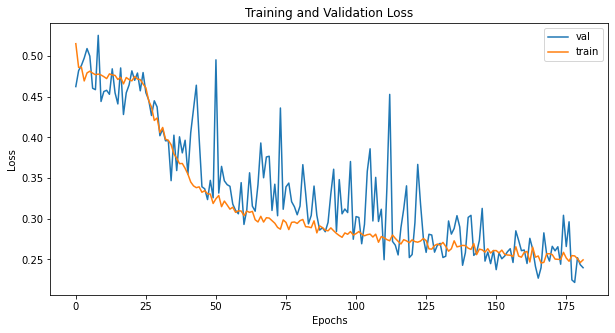

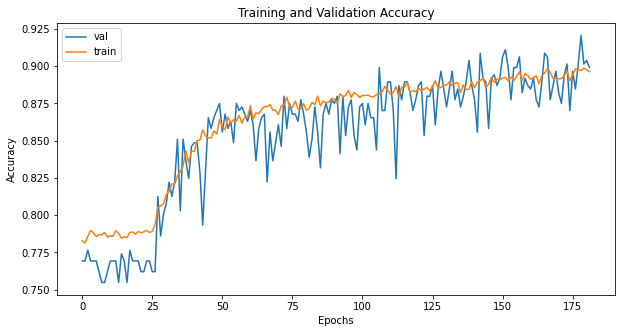

In [24]:
#Checking for overfitting/underfitting
val_loss_list = torch.from_numpy(np.asarray(torch.Tensor(val_loss_list).cpu()))
train_loss_list = torch.from_numpy(np.asarray(torch.Tensor(train_loss_list).cpu()))
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_loss_list,label="val")
plt.plot(train_loss_list,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

val_accuracy_list = torch.from_numpy(np.asarray(torch.Tensor(val_accuracy_list).cpu()))
train_accuracy_list = torch.from_numpy(np.asarray(torch.Tensor(train_accuracy_list).cpu()))
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accuracy_list,label="val")
plt.plot(train_accuracy_list,label="train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [25]:
actual_labels = []
predicted_labels = []

In [26]:
#Test accuracy
model.eval()
with torch.no_grad():
        test_accuracy = []
        
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)
            
            actual_labels.extend(np.asarray(label.cpu()).tolist())

            t_output = model(data)
            t_loss = criterion(t_output, label)
            
            predicted_labels.extend(np.asarray(t_output.argmax(dim=1).cpu()).tolist())

            acc = (t_output.argmax(dim=1) == label).float().mean()
            test_accuracy.append(acc)

        final_test_accuracy = sum(test_accuracy)/len(test_accuracy)
        print(f"test_acc : {final_test_accuracy:.4f}\n")

test_acc : 0.8904



In [27]:
print("Actual labels: ")
print(actual_labels)
print("Predicted labels: ")
print(predicted_labels)

Actual labels: 
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters in the model = {count_parameters(model)}")

Number of trainable parameters in the model = 4135426


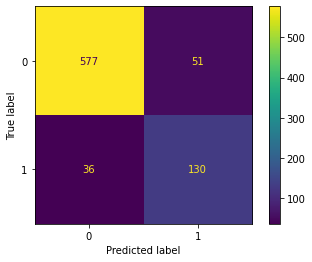

In [29]:
#Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

cnf_matrix = confusion_matrix(actual_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)

disp.plot()
plt.show()

In [30]:
#Specificity
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - cnf_matrix.sum(axis=0) - cnf_matrix.sum(axis=1) + np.diag(cnf_matrix)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

TNR = TN/(TN+FP)

print(f"Class wise specificity:")
print(f"Specificity = {TNR}\n")

print(f"Average specificity:")
print(f"Specificity = {np.average(np.array(TNR))}\n")

Class wise specificity:
Specificity = [0.78313253 0.91878981]

Average specificity:
Specificity = 0.8509611695188397



In [31]:
#Accuracy, Sensitivity, Precision, F1 score
from sklearn.metrics import classification_report

target_names = ['0', '1']
print(classification_report(actual_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       628
           1       0.72      0.78      0.75       166

    accuracy                           0.89       794
   macro avg       0.83      0.85      0.84       794
weighted avg       0.89      0.89      0.89       794



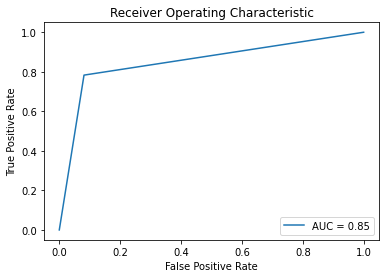

In [32]:
#ROC curve
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(actual_labels, predicted_labels)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [33]:
#AUC
print(f"AUC = {roc_auc}")

AUC = 0.8509611695188397
